In [2]:
import pandas as pd
from datetime import datetime, timedelta
import pickle
import os
import math
import numpy as np
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 
SEED = 5

In [3]:
#going to import my cleaned and organized data in order to create more features
#and run models I will go over the cleaning process in another article
roster = pd.read_csv('cleaned_prospect_data', sep ='|')

c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [5]:
pro_leagues = [ 'Liiga', 'SHL', 'Extraliga', 'KHL' ]
tier_2_pro = ['AHL', 'Mestis','Allsvenskan']
amateur_leagues = ['NCAA', 'USHL', 'QMJHL', 'OHL', 'WHL', 'USDP']

choices = ['pro', 'pro_tier_2', 'amateur']

conditions = [(roster['league'].isin(pro_leagues)),
              (roster['league'].isin(tier_2_pro)),
              (roster['league'].isin(amateur_leagues))]

roster['league_type'] = np.select(conditions, choices)

In [6]:
NHLe_rates = {'NCAA': .369, 'KHL': .727, 'SHL': .569, 'WHL': .305, 
             'OHL': .306, 'QMJHL': .262, 'Liiga':.435, 'Extraliga': .457,
             'average': .412}

def nhl_conversion(value, rates_dict):
    return rates_dict.get(value, .421)

roster['NHLe_rates'] = roster['league'].map(NHLe_rates, na_action=.412)
roster['NHLe_tp'] = roster['TP'] * roster.NHLe_rates
roster['NHLe_ppg'] = roster.NHLe_tp/roster.GP

In [7]:
roster = pd.get_dummies(roster, columns=['league'])

In [8]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [9]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [10]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


In [11]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


In [12]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[(roster['draft_year'] == 0)]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [13]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [14]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [15]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [16]:
#split draft_year_df into one for forwards and defensemen for model training and into
#one for just 2018 to look at model outputs 
draft_2018_df = draft_year_df[draft_year_df['season'] == 2018]
draft_year_df = draft_year_df[draft_year_df['season']<2018]
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [17]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,16.0,0.000000
0.50,49.0,0.000000
0.75,62.0,0.000000
0.95,70.0,0.306876
0.96,70.0,0.360854
0.97,71.0,0.445364
0.98,72.0,0.547620
0.99,72.0,0.686364


In [18]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .8, .94, .99])

,GP,nhl_pts_per_gp
0.25,16.0,0.000000
0.50,46.0,0.000000
0.75,61.0,0.000000
0.80,63.0,0.000000
0.94,69.0,0.181818
0.99,72.0,0.471976


In [19]:
#setting up games played and points bins to run the seperate models on
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_150_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=150), 1, 0)
draft_df_def['>_200_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.18_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.18), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)
draft_df_def['>_.47_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.47), 1, 0)

#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_150_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=150), 1, 0)
draft_df_fwd['>_200_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=200), 1, 0)
draft_df_fwd['>_.30_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.30), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)
draft_df_fwd['>_.68_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.68), 1, 0)

In [20]:
features = ['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_+/-',
            'goals_to_points', 'assists_to_points', 'age_adj_pts_g', 'league_Allsvenskan', 
            'league_Extraliga','league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA', 'league_OHL', 
            'league_QMJHL', 'league_SHL', 'league_USHL', 'league_WHL','NHLe_ppg', 'NHLe_tp']

In [21]:
#Splitting the data into 80/20 train test split with playing more than 72 games as the feature to predict 
#and greater than .25 points per game



X_train_def, X_test_def, \
y_train_def, y_test_def = train_test_split(draft_df_def[features],
                                                     draft_df_def[['>_72_nhl_gp', '>_150_nhl_gp','>_200_nhl_gp',
                                                                  '>_.18_nhl_pts_gp', '>_.25_nhl_pts_gp', 
                                                                  '>_.47_nhl_pts_gp']], 
                                                     test_size=0.2, random_state=SEED)




X_train_fwd, X_test_fwd, \
y_train_fwd, y_test_fwd = train_test_split(draft_df_fwd[features],
                                                     draft_df_fwd[['>_72_nhl_gp', '>_150_nhl_gp','>_200_nhl_gp',
                                                                  '>_.30_nhl_pts_gp', '>_.42_nhl_pts_gp', 
                                                                  '>_.68_nhl_pts_gp']], 
                                                     test_size=0.2, random_state=SEED)

In [22]:
log_params = {'penalty':['l2'], 'C':[.001, .01, .1, 1, 10, 100], 'class_weight':['balanced'],
              'solver':['newton-cg', 'lbfgs']}

tree_params = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
               'max_features': ['sqrt'],
               'max_depth': [10],
               'min_samples_split': [2],
               'min_samples_leaf': [1, 2, 4]}

dt_params = {'criterion': ['entropy', 'gini'],
             'splitter': ['best', 'random'],
             'max_depth': [1, 3, 5],
             'max_features': ['sqrt', 'log2', None],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]
             }
log_reg = LogisticRegression(max_iter=15000, random_state=SEED)
tree = RandomForestClassifier(random_state=SEED, bootstrap=True, class_weight='balanced',
                              n_jobs=-1)
dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
gnb_clf_def_gp_1 = GaussianNB()
gnb_clf_def_gp_2 = GaussianNB()
gnb_clf_def_gp_3 = GaussianNB()
gnb_clf_def_pts_1 = GaussianNB()
gnb_clf_def_pts_2 = GaussianNB()
gnb_clf_def_pts_3 = GaussianNB()
gnb_clf_fwd_gp_1 = GaussianNB()
gnb_clf_fwd_gp_2 = GaussianNB()
gnb_clf_fwd_gp_3 = GaussianNB()
gnb_clf_fwd_pts_1 = GaussianNB()
gnb_clf_fwd_pts_2 = GaussianNB()
gnb_clf_fwd_pts_3 = GaussianNB()

log_clf_def_gp_1 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_def_gp_2 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_def_gp_3 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_gp_1 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_gp_2 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_gp_3 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_def_pts_1 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_def_pts_2 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_def_pts_3 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_pts_1 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_pts_2 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)
log_clf_fwd_pts_3 = GridSearchCV(log_reg, log_params, scoring='neg_log_loss', cv=10)

tree_clf_def_gp_1 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_def_gp_2 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_def_gp_3 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_gp_1 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_gp_2 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_gp_3 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_def_pts_1 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_def_pts_2 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_def_pts_3 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_pts_1 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_pts_2 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)
tree_clf_fwd_pts_3 = GridSearchCV(tree, tree_params, scoring='neg_log_loss', cv=10)

dt_clf_def_gp_1 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_def_gp_2 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_def_gp_3 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_gp_1 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_gp_2 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_gp_3 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_def_pts_1 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_def_pts_2 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_def_pts_3 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_pts_1 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_pts_2 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)
dt_clf_fwd_pts_3 = GridSearchCV(dt, dt_params, scoring='neg_log_loss', cv=10)

In [54]:

#These next few cells are commented out because I've already trained all the models and pickled them
#If you were running the notebook from scratch you would uncomment these next 5 cells and run them as
#well. If you don't want to save the models you can skip pickling them and just run the training cells.
#train all the models
log_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
log_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
log_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
log_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
log_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
log_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
log_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
log_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
log_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
log_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
log_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
log_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Logistic Regression Finished Training')


Logistic Regression Finished Training


In [56]:

gnb_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
gnb_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
gnb_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
gnb_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
gnb_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
gnb_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
gnb_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
gnb_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
gnb_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
gnb_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
gnb_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
gnb_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('GNB Finished Training')


GNB Finished Training


In [25]:
'''
dt_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
dt_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
dt_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
dt_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
dt_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
dt_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
dt_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
dt_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
dt_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
dt_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
dt_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
dt_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Decision Tree Finished Training')
'''

"\ndt_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])\ndt_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])\ndt_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])\ndt_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])\ndt_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])\ndt_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])\ndt_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])\ndt_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])\ndt_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])\ndt_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])\ndt_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])\ndt_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])\nprint('Decision Tree Finished Training')\n"

In [26]:
'''
tree_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
tree_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
tree_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
tree_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
tree_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
tree_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
tree_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
tree_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
tree_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
tree_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
tree_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
tree_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Random Forest Finished Training')
'''

"\ntree_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])\ntree_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])\ntree_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])\ntree_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])\ntree_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])\ntree_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])\ntree_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])\ntree_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])\ntree_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])\ntree_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])\ntree_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])\ntree_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])\nprint('Random Forest Finished Training')\n"

In [27]:
'''
#saving random forest models
with open(os.path.join('trained_models','tree_clf_def_gp_1'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_1, f)

with open(os.path.join('trained_models','tree_clf_def_gp_2'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_2, f)

with open(os.path.join('trained_models','tree_clf_def_gp_3'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_1'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_2'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','tree_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','tree_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_3, f)
    '''

"\n#saving random forest models\nwith open(os.path.join('trained_models','tree_clf_def_gp_1'), 'wb') as f:\n    pickle.dump(tree_clf_def_gp_1, f)\n\nwith open(os.path.join('trained_models','tree_clf_def_gp_2'), 'wb') as f:\n    pickle.dump(tree_clf_def_gp_2, f)\n\nwith open(os.path.join('trained_models','tree_clf_def_gp_3'), 'wb') as f:\n    pickle.dump(tree_clf_def_gp_3, f)\n    \nwith open(os.path.join('trained_models','tree_clf_def_pts_1'), 'wb') as f:\n    pickle.dump(tree_clf_def_pts_1, f)\n    \nwith open(os.path.join('trained_models','tree_clf_def_pts_2'), 'wb') as f:\n    pickle.dump(tree_clf_def_pts_2, f)\n    \nwith open(os.path.join('trained_models','tree_clf_def_pts_3'), 'wb') as f:\n    pickle.dump(tree_clf_def_pts_3, f)\n    \nwith open(os.path.join('trained_models','tree_clf_fwd_gp_1'), 'wb') as f:\n    pickle.dump(tree_clf_fwd_gp_1, f)\n\nwith open(os.path.join('trained_models','tree_clf_fwd_gp_2'), 'wb') as f:\n    pickle.dump(tree_clf_fwd_gp_2, f)\n\nwith open(os.path

In [57]:

#saving gnb models
with open(os.path.join('trained_models','gnb_clf_def_gp_1'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_1, f)

with open(os.path.join('trained_models','gnb_clf_def_gp_2'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_2, f)

with open(os.path.join('trained_models','gnb_clf_def_gp_3'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_1'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_2'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','gnb_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','gnb_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_3, f)

In [58]:

#saving log regression models
with open(os.path.join('trained_models','log_clf_def_gp_1'), 'wb') as f:
    pickle.dump(log_clf_def_gp_1, f)

with open(os.path.join('trained_models','log_clf_def_gp_2'), 'wb') as f:
    pickle.dump(log_clf_def_gp_2, f)

with open(os.path.join('trained_models','log_clf_def_gp_3'), 'wb') as f:
    pickle.dump(log_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_1'), 'wb') as f:
    pickle.dump(log_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_2'), 'wb') as f:
    pickle.dump(log_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'wb') as f:
    pickle.dump(log_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','log_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','log_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_3, f)


In [30]:
'''
#saving decision tree models
with open(os.path.join('trained_models','dt_clf_def_gp_1'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_1, f)

with open(os.path.join('trained_models','dt_clf_def_gp_2'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_2, f)

with open(os.path.join('trained_models','dt_clf_def_gp_3'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_1'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_2'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_3'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','dt_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','dt_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_3, f)
'''

"\n#saving decision tree models\nwith open(os.path.join('trained_models','dt_clf_def_gp_1'), 'wb') as f:\n    pickle.dump(dt_clf_def_gp_1, f)\n\nwith open(os.path.join('trained_models','dt_clf_def_gp_2'), 'wb') as f:\n    pickle.dump(dt_clf_def_gp_2, f)\n\nwith open(os.path.join('trained_models','dt_clf_def_gp_3'), 'wb') as f:\n    pickle.dump(dt_clf_def_gp_3, f)\n    \nwith open(os.path.join('trained_models','dt_clf_def_pts_1'), 'wb') as f:\n    pickle.dump(dt_clf_def_pts_1, f)\n    \nwith open(os.path.join('trained_models','dt_clf_def_pts_2'), 'wb') as f:\n    pickle.dump(dt_clf_def_pts_2, f)\n    \nwith open(os.path.join('trained_models','dt_clf_def_pts_3'), 'wb') as f:\n    pickle.dump(dt_clf_def_pts_3, f)\n    \nwith open(os.path.join('trained_models','dt_clf_fwd_gp_1'), 'wb') as f:\n    pickle.dump(dt_clf_fwd_gp_1, f)\n\nwith open(os.path.join('trained_models','dt_clf_fwd_gp_2'), 'wb') as f:\n    pickle.dump(dt_clf_fwd_gp_2, f)\n\nwith open(os.path.join('trained_models','dt_clf_f

In [36]:
#loading decision tree models
with open(os.path.join('trained_models','dt_clf_fwd_pts_1'), 'rb') as f:
    dt_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_2'), 'rb') as f:
    dt_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_3'), 'rb') as f:
    dt_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_1'), 'rb') as f:
    dt_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_2'), 'rb') as f:
    dt_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_3'), 'rb') as f:
    dt_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_1'), 'rb') as f:
    dt_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_2'), 'rb') as f:
    dt_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_3'), 'rb') as f:
    dt_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_1'), 'rb') as f:
    dt_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_2'), 'rb') as f:
    dt_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_3'), 'rb') as f:
    dt_clf_def_gp_3 =  pickle.load(f)

In [44]:
#load random forest models
with open(os.path.join('trained_models','tree_clf_fwd_pts_1'), 'rb') as f:
    tree_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_2'), 'rb') as f:
    tree_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'rb') as f:
    tree_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_1'), 'rb') as f:
    tree_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_2'), 'rb') as f:
    tree_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'rb') as f:
    tree_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_1'), 'rb') as f:
    tree_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_2'), 'rb') as f:
    tree_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'rb') as f:
    tree_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_gp_1'), 'rb') as f:
    tree_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_gp_2'), 'rb') as f:
    tree_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'rb') as f:
    tree_clf_def_gp_3 =  pickle.load(f)

In [59]:
#load GNB classifier
with open(os.path.join('trained_models','gnb_clf_fwd_pts_1'), 'rb') as f:
    gnb_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_2'), 'rb') as f:
    gnb_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'rb') as f:
    gnb_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_1'), 'rb') as f:
    gnb_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_2'), 'rb') as f:
    gnb_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'rb') as f:
    gnb_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_1'), 'rb') as f:
    gnb_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_2'), 'rb') as f:
    gnb_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'rb') as f:
    gnb_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_gp_1'), 'rb') as f:
    gnb_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_gp_2'), 'rb') as f:
    gnb_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'rb') as f:
    gnb_clf_def_gp_3 =  pickle.load(f)

In [60]:
#loading log regression classifier
with open(os.path.join('trained_models','log_clf_fwd_pts_1'), 'rb') as f:
    log_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_2'), 'rb') as f:
    log_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'rb') as f:
    log_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_1'), 'rb') as f:
    log_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_2'), 'rb') as f:
    log_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'rb') as f:
    log_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_1'), 'rb') as f:
    log_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_2'), 'rb') as f:
    log_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'rb') as f:
    log_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_gp_1'), 'rb') as f:
    log_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_gp_2'), 'rb') as f:
    log_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'rb') as f:
    log_clf_def_gp_3 =  pickle.load(f)

In [40]:
#predicting random forest results on train data
train_tree_def_pts_1 = tree_clf_def_pts_1.predict(X_train_def)
train_tree_def_pts_2 = tree_clf_def_pts_2.predict(X_train_def)
train_tree_def_pts_3 = tree_clf_def_pts_3.predict(X_train_def)
train_tree_fwd_pts_1 = tree_clf_fwd_pts_1.predict(X_train_fwd)
train_tree_fwd_pts_2 = tree_clf_fwd_pts_2.predict(X_train_fwd)
train_tree_fwd_pts_3 = tree_clf_fwd_pts_3.predict(X_train_fwd)
train_tree_def_gp_1 = tree_clf_def_gp_1.predict(X_train_def)
train_tree_def_gp_2 = tree_clf_def_gp_2.predict(X_train_def)
train_tree_def_gp_3 = tree_clf_def_gp_3.predict(X_train_def)
train_tree_fwd_gp_1 = tree_clf_fwd_gp_1.predict(X_train_fwd)
train_tree_fwd_gp_2 = tree_clf_fwd_gp_2.predict(X_train_fwd)
train_tree_fwd_gp_3 = tree_clf_fwd_gp_3.predict(X_train_fwd)

In [61]:
#predicting logistic regression results on train data
train_log_def_pts_1 = log_clf_def_pts_1.predict(X_train_def)
train_log_def_pts_2 = log_clf_def_pts_2.predict(X_train_def)
train_log_def_pts_3 = log_clf_def_pts_3.predict(X_train_def)
train_log_fwd_pts_1 = log_clf_fwd_pts_1.predict(X_train_fwd)
train_log_fwd_pts_2 = log_clf_fwd_pts_2.predict(X_train_fwd)
train_log_fwd_pts_3 = log_clf_fwd_pts_3.predict(X_train_fwd)
train_log_def_gp_1 = log_clf_def_gp_1.predict(X_train_def)
train_log_def_gp_2 = log_clf_def_gp_2.predict(X_train_def)
train_log_def_gp_3 = log_clf_def_gp_3.predict(X_train_def)
train_log_fwd_gp_1 = log_clf_fwd_gp_1.predict(X_train_fwd)
train_log_fwd_gp_2 = log_clf_fwd_gp_2.predict(X_train_fwd)
train_log_fwd_gp_3 = log_clf_fwd_gp_3.predict(X_train_fwd)

In [48]:
#predicting decision tree regression results on train data
train_dt_def_pts_1 = dt_clf_def_pts_1.predict(X_train_def)
train_dt_def_pts_2 = dt_clf_def_pts_2.predict(X_train_def)
train_dt_def_pts_3 = dt_clf_def_pts_3.predict(X_train_def)
train_dt_fwd_pts_1 = dt_clf_fwd_pts_1.predict(X_train_fwd)
train_dt_fwd_pts_2 = dt_clf_fwd_pts_2.predict(X_train_fwd)
train_dt_fwd_pts_3 = dt_clf_fwd_pts_3.predict(X_train_fwd)
train_dt_def_gp_1 = dt_clf_def_gp_1.predict(X_train_def)
train_dt_def_gp_2 = dt_clf_def_gp_2.predict(X_train_def)
train_dt_def_gp_3 = dt_clf_def_gp_3.predict(X_train_def)
train_dt_fwd_gp_1 = dt_clf_fwd_gp_1.predict(X_train_fwd)
train_dt_fwd_gp_2 = dt_clf_fwd_gp_2.predict(X_train_fwd)
train_dt_fwd_gp_3 = dt_clf_fwd_gp_3.predict(X_train_fwd)

In [62]:
#predicting gnbistic regression results on train data
train_gnb_def_pts_1 = gnb_clf_def_pts_1.predict(X_train_def)
train_gnb_def_pts_2 = gnb_clf_def_pts_2.predict(X_train_def)
train_gnb_def_pts_3 = gnb_clf_def_pts_3.predict(X_train_def)
train_gnb_fwd_pts_1 = gnb_clf_fwd_pts_1.predict(X_train_fwd)
train_gnb_fwd_pts_2 = gnb_clf_fwd_pts_2.predict(X_train_fwd)
train_gnb_fwd_pts_3 = gnb_clf_fwd_pts_3.predict(X_train_fwd)
train_gnb_def_gp_1 = gnb_clf_def_gp_1.predict(X_train_def)
train_gnb_def_gp_2 = gnb_clf_def_gp_2.predict(X_train_def)
train_gnb_def_gp_3 = gnb_clf_def_gp_3.predict(X_train_def)
train_gnb_fwd_gp_1 = gnb_clf_fwd_gp_1.predict(X_train_fwd)
train_gnb_fwd_gp_2 = gnb_clf_fwd_gp_2.predict(X_train_fwd)
train_gnb_fwd_gp_3 = gnb_clf_fwd_gp_3.predict(X_train_fwd)

In [63]:
#creating train dependent sets on which to train the xgboost model for points model
test_def_pts_1 = np.concatenate((train_gnb_def_pts_1.reshape(-1,1), train_dt_def_pts_1.reshape(-1,1), 
                            train_tree_def_pts_1.reshape(-1,1), train_log_def_pts_1.reshape(-1,1)), axis=1)

test_def_pts_2 = np.concatenate((train_gnb_def_pts_2.reshape(-1,1), train_dt_def_pts_2.reshape(-1,1), 
                            train_tree_def_pts_2.reshape(-1,1), train_log_def_pts_2.reshape(-1,1)), axis=1)

test_def_pts_3 = np.concatenate((train_gnb_def_pts_3.reshape(-1,1), train_dt_def_pts_3.reshape(-1,1), 
                            train_tree_def_pts_3.reshape(-1,1), train_log_def_pts_3.reshape(-1,1)), axis=1)

test_fwd_pts_1 = np.concatenate((train_gnb_fwd_pts_1.reshape(-1,1), train_dt_fwd_pts_1.reshape(-1,1), 
                            train_tree_fwd_pts_1.reshape(-1,1), train_log_fwd_pts_1.reshape(-1,1)), axis=1)

test_fwd_pts_2 = np.concatenate((train_gnb_fwd_pts_2.reshape(-1,1), train_dt_fwd_pts_2.reshape(-1,1), 
                            train_tree_fwd_pts_2.reshape(-1,1), train_log_fwd_pts_2.reshape(-1,1)), axis=1)

test_fwd_pts_3 = np.concatenate((train_gnb_fwd_pts_3.reshape(-1,1), train_dt_fwd_pts_3.reshape(-1,1), 
                            train_tree_fwd_pts_3.reshape(-1,1), train_log_fwd_pts_3.reshape(-1,1)), axis=1)

In [65]:
#creating train dependent sets on which to test the xgboost games played models
test_def_gp_1 = np.concatenate((train_gnb_def_gp_1.reshape(-1,1), train_dt_def_gp_1.reshape(-1,1), 
                            train_tree_def_gp_1.reshape(-1,1), train_log_def_gp_1.reshape(-1,1)), axis=1)

test_def_gp_2 = np.concatenate((train_gnb_def_gp_2.reshape(-1,1), train_dt_def_gp_2.reshape(-1,1), 
                            train_tree_def_gp_2.reshape(-1,1), train_log_def_gp_2.reshape(-1,1)), axis=1)

test_def_gp_3 = np.concatenate((train_gnb_def_gp_3.reshape(-1,1), train_dt_def_gp_3.reshape(-1,1), 
                            train_tree_def_gp_3.reshape(-1,1), train_log_def_gp_3.reshape(-1,1)), axis=1)

test_fwd_gp_1 = np.concatenate((train_gnb_fwd_gp_1.reshape(-1,1), train_dt_fwd_gp_1.reshape(-1,1), 
                            train_tree_fwd_gp_1.reshape(-1,1), train_log_fwd_gp_1.reshape(-1,1)), axis=1)

test_fwd_gp_2 = np.concatenate((train_gnb_fwd_gp_2.reshape(-1,1), train_dt_fwd_gp_2.reshape(-1,1), 
                            train_tree_fwd_gp_2.reshape(-1,1), train_log_fwd_gp_2.reshape(-1,1)), axis=1)

test_fwd_gp_3 = np.concatenate((train_gnb_fwd_gp_3.reshape(-1,1), train_dt_fwd_gp_3.reshape(-1,1), 
                            train_tree_fwd_gp_3.reshape(-1,1), train_log_fwd_gp_3.reshape(-1,1)), axis=1)

In [66]:
#predicting random forest results on test data
pred_tree_def_pts_1 = tree_clf_def_pts_1.predict(X_test_def)
pred_tree_def_pts_2 = tree_clf_def_pts_2.predict(X_test_def)
pred_tree_def_pts_3 = tree_clf_def_pts_3.predict(X_test_def)
pred_tree_fwd_pts_1 = tree_clf_fwd_pts_1.predict(X_test_fwd)
pred_tree_fwd_pts_2 = tree_clf_fwd_pts_2.predict(X_test_fwd)
pred_tree_fwd_pts_3 = tree_clf_fwd_pts_3.predict(X_test_fwd)
pred_tree_def_gp_1 = tree_clf_def_gp_1.predict(X_test_def)
pred_tree_def_gp_2 = tree_clf_def_gp_2.predict(X_test_def)
pred_tree_def_gp_3 = tree_clf_def_gp_3.predict(X_test_def)
pred_tree_fwd_gp_1 = tree_clf_fwd_gp_1.predict(X_test_fwd)
pred_tree_fwd_gp_2 = tree_clf_fwd_gp_2.predict(X_test_fwd)
pred_tree_fwd_gp_3 = tree_clf_fwd_gp_3.predict(X_test_fwd)

In [67]:
#predicting decision dt results on test data
pred_dt_def_pts_1 = dt_clf_def_pts_1.predict(X_test_def)
pred_dt_def_pts_2 = dt_clf_def_pts_2.predict(X_test_def)
pred_dt_def_pts_3 = dt_clf_def_pts_3.predict(X_test_def)
pred_dt_fwd_pts_1 = dt_clf_fwd_pts_1.predict(X_test_fwd)
pred_dt_fwd_pts_2 = dt_clf_fwd_pts_2.predict(X_test_fwd)
pred_dt_fwd_pts_3 = dt_clf_fwd_pts_3.predict(X_test_fwd)
pred_dt_def_gp_1 = dt_clf_def_gp_1.predict(X_test_def)
pred_dt_def_gp_2 = dt_clf_def_gp_2.predict(X_test_def)
pred_dt_def_gp_3 = dt_clf_def_gp_3.predict(X_test_def)
pred_dt_fwd_gp_1 = dt_clf_fwd_gp_1.predict(X_test_fwd)
pred_dt_fwd_gp_2 = dt_clf_fwd_gp_2.predict(X_test_fwd)
pred_dt_fwd_gp_3 = dt_clf_fwd_gp_3.predict(X_test_fwd)

In [68]:
#predicting log regression results on test data
pred_log_def_pts_1 = log_clf_def_pts_1.predict(X_test_def)
pred_log_def_pts_2 = log_clf_def_pts_2.predict(X_test_def)
pred_log_def_pts_3 = log_clf_def_pts_3.predict(X_test_def)
pred_log_fwd_pts_1 = log_clf_fwd_pts_1.predict(X_test_fwd)
pred_log_fwd_pts_2 = log_clf_fwd_pts_2.predict(X_test_fwd)
pred_log_fwd_pts_3 = log_clf_fwd_pts_3.predict(X_test_fwd)
pred_log_def_gp_1 = log_clf_def_gp_1.predict(X_test_def)
pred_log_def_gp_2 = log_clf_def_gp_2.predict(X_test_def)
pred_log_def_gp_3 = log_clf_def_gp_3.predict(X_test_def)
pred_log_fwd_gp_1 = log_clf_fwd_gp_1.predict(X_test_fwd)
pred_log_fwd_gp_2 = log_clf_fwd_gp_2.predict(X_test_fwd)
pred_log_fwd_gp_3 = log_clf_fwd_gp_3.predict(X_test_fwd)

In [69]:
#predicting GNB results on test data
pred_gnb_def_pts_1 = gnb_clf_def_pts_1.predict(X_test_def)
pred_gnb_def_pts_2 = gnb_clf_def_pts_2.predict(X_test_def)
pred_gnb_def_pts_3 = gnb_clf_def_pts_3.predict(X_test_def)
pred_gnb_fwd_pts_1 = gnb_clf_fwd_pts_1.predict(X_test_fwd)
pred_gnb_fwd_pts_2 = gnb_clf_fwd_pts_2.predict(X_test_fwd)
pred_gnb_fwd_pts_3 = gnb_clf_fwd_pts_3.predict(X_test_fwd)
pred_gnb_def_gp_1 = gnb_clf_def_gp_1.predict(X_test_def)
pred_gnb_def_gp_2 = gnb_clf_def_gp_2.predict(X_test_def)
pred_gnb_def_gp_3 = gnb_clf_def_gp_3.predict(X_test_def)
pred_gnb_fwd_gp_1 = gnb_clf_fwd_gp_1.predict(X_test_fwd)
pred_gnb_fwd_gp_2 = gnb_clf_fwd_gp_2.predict(X_test_fwd)
pred_gnb_fwd_gp_3 = gnb_clf_fwd_gp_3.predict(X_test_fwd)

In [70]:
#creating test dependent sets on which to test the xgboost model for points model
def_pts_1 = np.concatenate((pred_gnb_def_pts_1.reshape(-1,1), pred_dt_def_pts_1.reshape(-1,1), 
                            pred_tree_def_pts_1.reshape(-1,1), pred_log_def_pts_1.reshape(-1,1)), axis=1)

def_pts_2 = np.concatenate((pred_gnb_def_pts_2.reshape(-1,1), pred_dt_def_pts_2.reshape(-1,1), 
                            pred_tree_def_pts_2.reshape(-1,1), pred_log_def_pts_2.reshape(-1,1)), axis=1)

def_pts_3 = np.concatenate((pred_gnb_def_pts_3.reshape(-1,1), pred_dt_def_pts_3.reshape(-1,1), 
                            pred_tree_def_pts_3.reshape(-1,1), pred_log_def_pts_3.reshape(-1,1)), axis=1)

fwd_pts_1 = np.concatenate((pred_gnb_fwd_pts_1.reshape(-1,1), pred_dt_fwd_pts_1.reshape(-1,1), 
                            pred_tree_fwd_pts_1.reshape(-1,1), pred_log_fwd_pts_1.reshape(-1,1)), axis=1)

fwd_pts_2 = np.concatenate((pred_gnb_fwd_pts_2.reshape(-1,1), pred_dt_fwd_pts_2.reshape(-1,1), 
                            pred_tree_fwd_pts_2.reshape(-1,1), pred_log_fwd_pts_2.reshape(-1,1)), axis=1)

fwd_pts_3 = np.concatenate((pred_gnb_fwd_pts_3.reshape(-1,1), pred_dt_fwd_pts_3.reshape(-1,1), 
                            pred_tree_fwd_pts_3.reshape(-1,1), pred_log_fwd_pts_3.reshape(-1,1)), axis=1)

In [71]:
#creating test dependent sets on which to test the xgboost games played models
def_gp_1 = np.concatenate((pred_gnb_def_gp_1.reshape(-1,1), pred_dt_def_gp_1.reshape(-1,1), 
                            pred_tree_def_gp_1.reshape(-1,1), pred_log_def_gp_1.reshape(-1,1)), axis=1)

def_gp_2 = np.concatenate((pred_gnb_def_gp_2.reshape(-1,1), pred_dt_def_gp_2.reshape(-1,1), 
                            pred_tree_def_gp_2.reshape(-1,1), pred_log_def_gp_2.reshape(-1,1)), axis=1)

def_gp_3 = np.concatenate((pred_gnb_def_gp_3.reshape(-1,1), pred_dt_def_gp_3.reshape(-1,1), 
                            pred_tree_def_gp_3.reshape(-1,1), pred_log_def_gp_3.reshape(-1,1)), axis=1)

fwd_gp_1 = np.concatenate((pred_gnb_fwd_gp_1.reshape(-1,1), pred_dt_fwd_gp_1.reshape(-1,1), 
                            pred_tree_fwd_gp_1.reshape(-1,1), pred_log_fwd_gp_1.reshape(-1,1)), axis=1)

fwd_gp_2 = np.concatenate((pred_gnb_fwd_gp_2.reshape(-1,1), pred_dt_fwd_gp_2.reshape(-1,1), 
                            pred_tree_fwd_gp_2.reshape(-1,1), pred_log_fwd_gp_2.reshape(-1,1)), axis=1)

fwd_gp_3 = np.concatenate((pred_gnb_fwd_gp_3.reshape(-1,1), pred_dt_fwd_gp_3.reshape(-1,1), 
                            pred_tree_fwd_gp_3.reshape(-1,1), pred_log_fwd_gp_3.reshape(-1,1)), axis=1)

In [73]:
X_test_fwd.shape

(1122, 23)

0.6680839002267572


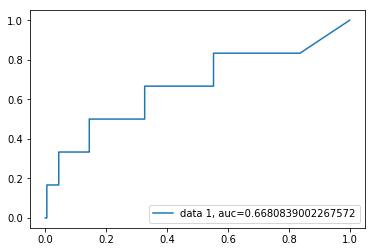

In [64]:
#calculating auc_score for plyaing more than 39 NHL games the median for defensemen

#get probability scores for each player playing over 50 games in NHL
pred_gp_log = tree_clf_def_pts_3.predict(X_test_def)
y_pred_proba_log =  tree_clf_def_pts_3.predict_proba(X_test_def)[:,1]
auc = roc_auc_score(y_test_def.loc[:, '>_.47_nhl_pts_gp'], y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_def.loc[:, '>_.47_nhl_pts_gp'],  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8922332069339113


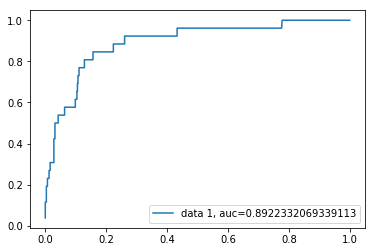

In [25]:
#calculating auc_score for plyaing more than 39 NHL games the median for fwdensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
pred_pts_log = log_reg_fwd_pts.predict(X_test_pts)
y_pred_proba_log =  log_reg_fwd_pts.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pts, pred_pts_log)

array([[468, 100],
       [  4,  22]])

In [27]:
from sklearn.naive_bayes import GaussianNB
gnb_gp_def = GaussianNB()
gnb_pts_def = GaussianNB()
gnb_gp_def.fit(X_train_gp, y_train_gp)
gnb_pts_def.fit(X_train_pts, y_train_pts)


GaussianNB(priors=None)

0.777973740936704


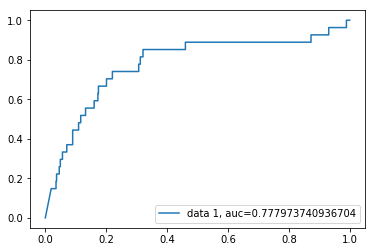

In [28]:
#naive bayes predictor
gnb_pred_gp = gnb_gp_def.predict(X_test_gp)
y_pred_prob_gnb_gp =  gnb_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_gnb_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_gnb_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8326787648970748


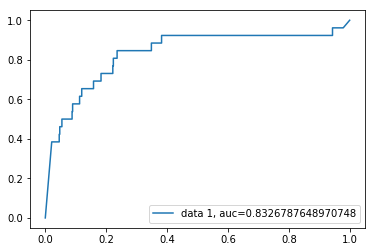

In [29]:
#naive bayes predictor
gnb_pred_pts = gnb_pts_def.predict(X_test_pts)
y_pred_prob_gnb_pts =  gnb_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_gnb_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_gnb_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [73]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree_gp_def = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 100,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree_pts_def = RandomForest(
                        n_jobs= -1,
                        n_estimators= 500,
                         #warm_start= True, 
                         #'max_features': 0.2,
                        max_depth= 100,
                        min_samples_leaf= 2,
                        max_features = 'sqrt',
                        verbose=0,
                        class_weight='balanced')
tree_gp_def.fit(X_train_gp, y_train_gp)
tree_pts_def.fit(X_train_pts, y_train_pts)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

0.8589718466261677


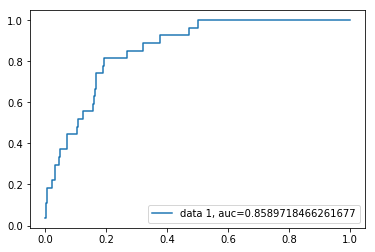

In [74]:
#random forest predictor
tree_pred_gp_def = tree_gp_def.predict(X_test_gp)
y_prob_tree_gp_def =  tree_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_tree_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_tree_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8823131094257857


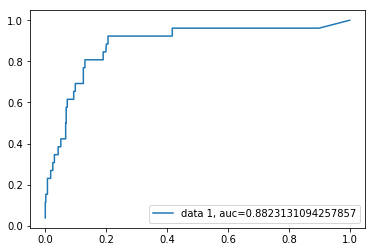

In [75]:
#random forest predictor
tree_pred_pts_def = tree_pts_def.predict(X_test_pts)
y_prob_tree_pts_def =  tree_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_tree_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_tree_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt_gp_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_def.fit(X_train_gp, y_train_gp)
dt_pts_def.fit(X_train_pts, y_train_pts)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.7150695669214188


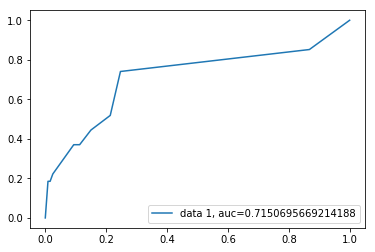

In [34]:
#Decision Tree
dt_pred_gp_def = dt_gp_def.predict(X_test_gp)
y_prob_dt_gp_def =  dt_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_dt_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_dt_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7198334236186348


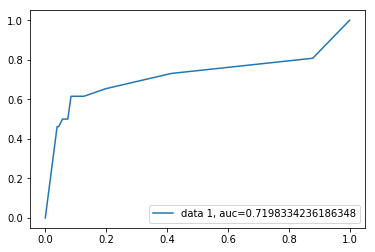

In [35]:
#Decision Tree
dt_pred_pts_def = dt_pts_def.predict(X_test_pts)
y_prob_dt_pts_def =  dt_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_dt_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_dt_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [36]:
#calculate Decision Tree prediction probabilities
predictions = dt_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_dt'] = predictions_2018

In [37]:
#calculate random forest prediction probabilities
predictions = tree_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_tree'] = predictions_2018

In [38]:
#calculate random forest prediction probabilities
predictions = gnb_gp_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_gnb'] = predictions_2018

In [39]:
#calculate random forest prediction probabilities
predictions = log_reg_def_gp.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_gp.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_log'] = predictions_2018

In [40]:
#calculate Decision Tree prediction probabilities
predictions = dt_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_dt'] = predictions_2018

In [41]:
#calculate random forest prediction probabilities
predictions = tree_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_tree'] = predictions_2018

In [42]:
#calculate random forest prediction probabilities
predictions = gnb_pts_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_gnb'] = predictions_2018

In [43]:
#calculate random forest prediction probabilities
predictions = log_reg_def_pts.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_pts.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_log'] = predictions_2018

In [44]:
for x, y in zip(['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL','NHLe_ppg'],list(log_reg_def_pts.coef_[0])):
    print('{}: {}'.format(x,y))

GP: -0.01768489078989946
G: 0.1276084692090362
A: 0.04232261478807715
playoff_GP: -0.007509078160953638
playoff_G: 0.20593781602678912
playoff_A: 0.21114298302779597
playoff_TP: 0.03217941805540136
playoff_+/-: 1.0405363864462354
goals_to_points: 1.018061537300105
assists_to_points: 0.7711800858313875
age_adj_pts_g: -0.669302449347396
league_Allsvenskan: -1.4590133120200188
league_Extraliga: 1.512404287249507
league_KHL: 1.0183729602829583
league_Liiga: 1.6650111257590363
league_Mestis: 0.7618872871640355
league_NCAA: -2.053320323509141
league_OHL: -2.4395224254579904
league_QMJHL: 1.506333846899854
league_SHL: 0.2695057374387444
league_USHL: -1.4978661924802381
league_WHL: -0.02771591764912521
NHLe_ppg: 0.10960741114072299


In [45]:
draft_2018_df_def['model_average_games'] = draft_2018_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)

draft_2018_df_def['model_average_pts'] = draft_2018_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree'
]].mean(axis=1)

In [46]:
draft_2018_df_def[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_games']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_games
557,Adam Boqvist,0.323061,4.309148e-11,0.193087,0.000000,0.129037
558,Adam Boqvist,0.664621,5.274831e-01,0.244549,0.921836,0.589622
752,Adam Gaudreau,0.019674,1.225789e-08,0.045859,0.082448,0.036995
768,Adam Ginning,0.779517,7.887514e-01,0.419874,0.921836,0.727495
980,Adam McCormick,0.522860,9.857090e-01,0.505157,0.450440,0.616042
1213,Adam Samuelsson,0.604036,5.350499e-04,0.495574,0.505499,0.401411
1214,Adam Samuelsson,0.525501,5.458039e-05,0.653855,0.839970,0.504845
1386,Adrien Beraldo,0.159895,3.111640e-05,0.112231,0.082448,0.088651
1423,Aidan Fulp,0.399557,2.409195e-05,0.194076,0.082448,0.169026
1435,Aidan Timmermans,0.130366,1.900246e-05,0.158205,0.082448,0.092759


In [47]:
draft_rankings_2018_def = draft_2018_df_def[['Player', 'model_average_games', 
                                         'model_average_pts']].groupby(['Player'], as_index=False).\
mean().sort_values(['model_average_pts'], ascending=False)

In [48]:
draft_rankings_2018_def = draft_rankings_2018_def.reset_index(drop=True)
draft_rankings_2018_def.index = np.arange(1,len(draft_rankings_2018_def)+1)
draft_rankings_2018_def.head(30)

,Player,model_average_games,model_average_pts
1,Ty Smith,0.943510,0.936023
2,Quinn Hughes,0.936019,0.934302
3,Alexander Alexeyev,0.919373,0.910447
4,Calen Addison,0.915506,0.902625
5,Nicolas Beaudin,0.940848,0.898703
6,Evan Bouchard,0.918708,0.886471
7,Ryan Merkley,0.909184,0.883379
8,Noah Dobson,0.923732,0.871540
9,Rasmus Dahlin,0.911068,0.835606
10,Jett Woo,0.716758,0.790669


In [49]:
draft_df_def['model_average_>_.25'] = draft_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree']].mean(axis=1)

draft_df_def['model_average_>_72_games']= draft_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt']].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average_>_.25'], ascending=False)

In [50]:
draft_rankings_def = draft_df_def[['Player', 'model_average_>_.25',
                               'model_average_>_72_games']].groupby(['Player'], as_index=False)\
.mean().sort_values(['model_average_>_.25'], ascending=False)

In [51]:
draft_rankings_def = draft_rankings_def.reset_index(drop=True)
draft_rankings_def.index = np.arange(1,len(draft_rankings_def)+1)
draft_rankings_def.head(30)

,Player,model_average_>_.25,model_average_>_72_games
1,P.K. Subban,0.970601,0.972588
2,Cody Ceci,0.969128,0.975233
3,Cam Barker,0.966878,0.976012
4,Seth Jones,0.965760,0.967694
5,Dougie Hamilton,0.965144,0.974028
6,Drew Doughty,0.963595,0.970774
7,Alex Pietrangelo,0.960022,0.965307
8,Michael Del Zotto,0.959001,0.960489
9,Vince Dunn,0.957128,0.972718
10,Derrick Pouliot,0.954347,0.973682


In [68]:
y_test_pts.shape

(1122,)

In [69]:
#Fit log reg to both classes
logreggames = LogisticRegression(class_weight='balanced')
logregpoints = LogisticRegression(class_weight='balanced')
logreggames.fit(X_train_gp, y_train_gp)
logregpoints.fit(X_train_gp, y_train_gp)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.9011501959975242


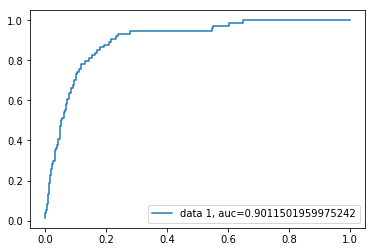

In [70]:
#get logreg probability scores for each player playing over 72 games in NHL
predict_gp = logreggames.predict(X_test_gp)
y_pred_proba_gp =  logreggames.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9331036768709898


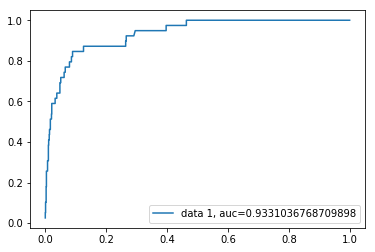

In [71]:
#get logreg probability scores for each player scoring over .42 pts per game in NHL
predict_pts = logregpoints.predict(X_test_pts)
y_pred_proba_pts =  logregpoints.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [72]:
confusion_matrix(y_test_gp, predict_gp)

array([[852, 196],
       [ 10,  64]])

In [73]:
confusion_matrix(y_test_pts, predict_pts)

array([[863, 220],
       [  5,  34]])

In [74]:
from sklearn.naive_bayes import GaussianNB
gnb_pts_fwd = GaussianNB()
gnb_gp_fwd = GaussianNB()
gnb_pts_fwd.fit(X_train_pts, y_train_pts)
gnb_gp_fwd.fit(X_train_gp, y_train_gp)
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)


In [75]:
confusion_matrix(y_test_gp, gnb_gp_pred)

array([[914, 134],
       [ 25,  49]])

In [76]:
confusion_matrix(y_test_pts, gnb_pts_pred)

array([[969, 114],
       [ 13,  26]])

0.8520218691974418


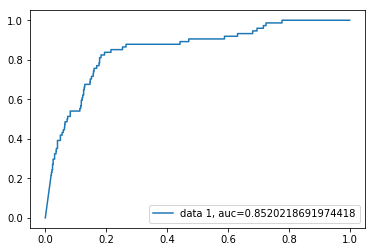

In [77]:
#get GNB probability scores for each player playing over 72 games in NHL
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = gnb_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9067878873973058


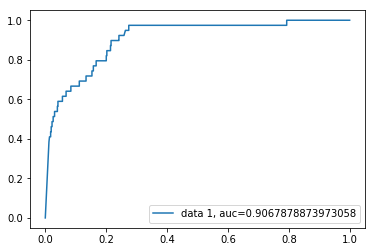

In [78]:
#get GNB probability scores for each player scoring over .42 points per games in NHL
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = gnb_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [79]:
tree_pts_fwd = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced')

tree_gp_fwd = RandomForest(n_jobs= -1, n_estimators= 500,
                       #warm_start= True, 
                       #'max_features': 0.2,
                       max_depth= 6, min_samples_leaf= 2, max_features = 'sqrt',
                       verbose=0, class_weight='balanced')

tree_pts_fwd.fit(X_train_pts, y_train_pts)
tree_gp_fwd.fit(X_train_gp, y_train_gp)
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)

In [80]:
confusion_matrix(y_test_gp, tree_gp_pred)

array([[924, 124],
       [ 22,  52]])

In [81]:
confusion_matrix(y_test_pts, tree_pts_pred)

array([[1023,   60],
       [  12,   27]])

0.8808541365793274


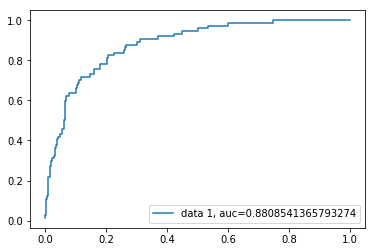

In [82]:
#get Random Forest probability scores for each forward playing over 72 games in NHL
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = tree_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9118426971612569


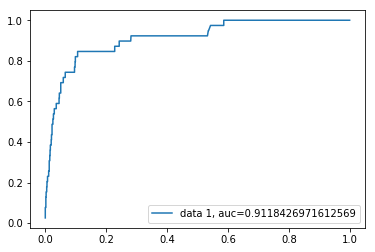

In [83]:
#get Random Forest probability scores for each forward scoring over .42 points per games in NHL
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = tree_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [84]:
from sklearn.tree import DecisionTreeClassifier

dt_pts_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_fwd.fit(X_train_pts, y_train_pts)
dt_gp_fwd.fit(X_train_gp, y_train_gp)
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)


In [85]:
confusion_matrix(y_test_pts, dt_pred_pts)

array([[954, 129],
       [  9,  30]])

In [86]:
confusion_matrix(y_test_gp, dt_pred_gp)

array([[889, 159],
       [ 22,  52]])

0.8057367959562617


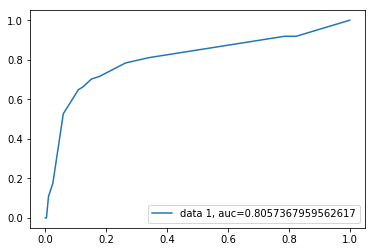

In [87]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)
y_pred_prob_dt_gp =  dt_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_dt_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_dt_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8136231266425171


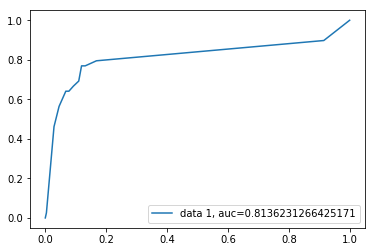

In [88]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
y_pred_prob_dt_pts =  dt_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_dt_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_dt_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [90]:
#calculate SVM prediction probabilities
predictions = dt_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_dt'] = predictions_2018

In [91]:
#calculate random forest prediction probabilities
predictions = tree_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_tree'] = predictions_2018




In [92]:
#calculate random forest prediction probabilities
predictions = gnb_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_gnb'] = predictions_2018


In [93]:
#calculate random forest prediction probabilities
predictions = logreggames.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logreggames.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_log'] = predictions_2018

In [99]:
#calculate SVM prediction probabilities
predictions = dt_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_dt'] = predictions_2018

#calculate random forest prediction probabilities
predictions = tree_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_tree'] = predictions_2018




#calculate random forest prediction probabilities
predictions = gnb_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions_2018


#calculate random forest prediction probabilities
predictions = logregpoints.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logregpoints.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_log'] = predictions_2018

In [100]:
draft_2018_df_fwd['model_average_gp'] = draft_2018_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_2018_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
6309,Andrei Svechnikov,0.991447,1.000000,0.911421,0.976536,0.969851
34049,Filip Zadina,0.942318,1.000000,0.929880,0.976536,0.962183
49861,Joel Farabee,0.955651,0.990292,0.705193,0.978205,0.907335
95458,Ryan McLeod,0.867723,1.000000,0.859446,0.880874,0.902010
1421,Aidan Dudas,0.919942,1.000000,0.803899,0.880874,0.901179
10389,Barrett Hayton,0.898828,1.000000,0.785269,0.880874,0.891243
40988,Jacob Olofsson,0.968289,0.999943,0.685507,0.880874,0.883653
17305,Cameron Hillis,0.839692,0.999878,0.803112,0.880874,0.880889
21566,Cole Fonstad,0.877228,1.000000,0.727655,0.880874,0.871439
109398,Ty Dellandrea,0.844702,0.997097,0.761663,0.880874,0.871084


In [101]:
draft_2018_df_fwd['model_average_pts'] = draft_2018_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_2018_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
6309,Andrei Svechnikov,0.991447,1.000000,0.820278,0.959402,0.942782
34049,Filip Zadina,0.942318,1.000000,0.832259,0.959402,0.933495
83824,Oliver Wahlstrom,0.988300,0.999980,0.659362,0.959402,0.901761
1421,Aidan Dudas,0.919942,0.999947,0.734710,0.922462,0.894265
1587,Akil Thomas,0.929796,1.000000,0.580806,0.959402,0.867501
10389,Barrett Hayton,0.898828,1.000000,0.621935,0.922462,0.860806
95458,Ryan McLeod,0.867723,0.999963,0.651007,0.922462,0.860289
40988,Jacob Olofsson,0.968289,0.996867,0.620160,0.854667,0.859996
5241,Allan McShane,0.832515,0.994357,0.601143,0.922462,0.837619
17305,Cameron Hillis,0.839692,0.990138,0.566363,0.922462,0.829664


In [102]:
draft_rankings_2018_fwd = draft_2018_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [103]:
draft_rankings_2018_fwd = draft_rankings_2018_fwd.reset_index(drop=True)
draft_rankings_2018_fwd.index = np.arange(1,len(draft_rankings_2018_fwd)+1)
draft_rankings_2018_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Andrei Svechnikov,0.942782,0.969851
2,Filip Zadina,0.933495,0.962183
3,Aidan Dudas,0.894265,0.901179
4,Akil Thomas,0.867501,0.645411
5,Barrett Hayton,0.860806,0.891243
6,Ryan McLeod,0.860289,0.902010
7,Jacob Olofsson,0.859996,0.883653
8,Allan McShane,0.837619,0.867203
9,Cameron Hillis,0.829664,0.880889
10,Joseph Veleno,0.823745,0.617210


In [104]:
draft_df_fwd['model_average_pts'] = draft_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
103403,Taylor Hall,0.999229,1.0,0.982682,0.959402,0.985328
52495,Jonathan Drouin,0.997947,1.0,0.980891,0.959402,0.984560
16386,Bryan Little,0.995010,1.0,0.978087,0.959402,0.983125
22476,Connor McDavid,0.999900,1.0,0.972183,0.959402,0.982871
72494,Matthew Tkachuk,0.999291,1.0,0.971652,0.959402,0.982586
2301,Alex DeBrincat,0.996675,1.0,0.968822,0.959402,0.981225
80103,Nathan MacKinnon,0.994647,1.0,0.967201,0.959402,0.980312
96524,Sam Gagner,0.998746,1.0,0.962895,0.959402,0.980260
79513,Mitchell Marner,0.998650,1.0,0.960179,0.959402,0.979558
92631,Robby Fabbri,0.997380,1.0,0.959604,0.959402,0.979096


In [105]:
draft_df_fwd['model_average_gp'] = draft_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
103403,Taylor Hall,0.999229,1.0,0.977423,0.976536,0.988297
85823,Patrick Kane,0.999752,1.0,0.976742,0.976536,0.988258
52495,Jonathan Drouin,0.997947,1.0,0.977966,0.976536,0.988112
2301,Alex DeBrincat,0.996675,1.0,0.978998,0.976536,0.988052
100238,Sidney Crosby,0.999850,1.0,0.971616,0.976536,0.987000
22476,Connor McDavid,0.999900,1.0,0.970832,0.976536,0.986817
92631,Robby Fabbri,0.997380,1.0,0.972071,0.976536,0.986497
51567,John Tavares,0.998101,1.0,0.971345,0.976536,0.986495
16386,Bryan Little,0.995010,1.0,0.970757,0.976536,0.985576
46630,Jeff Skinner,0.998010,1.0,0.967291,0.976536,0.985459


In [106]:
draft_rankings_fwd = draft_df_fwd[['Player', 'season', 'model_average_pts',
                               'model_average_gp']].groupby(['Player', 'season'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [107]:
draft_rankings_fwd = draft_rankings_fwd.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_2017 = draft_rankings_fwd[draft_rankings_fwd['season']==2017].head(30)
draft_rankings_2017 = draft_rankings_2017.reset_index(drop=True)
draft_rankings_2017.index = np.arange(1,len(draft_rankings_2017)+1)

In [112]:
draft_rankings_fwd[draft_rankings_fwd['season'] == 2013]

,Player,season,model_average_pts,model_average_gp
2,Jonathan Drouin,2013,0.984560,0.988112
7,Nathan MacKinnon,2013,0.980312,0.983318
25,Max Domi,2013,0.973029,0.981615
55,Hunter Shinkaruk,2013,0.951646,0.955698
56,Sean Monahan,2013,0.951029,0.958149
80,Anthony Mantha,2013,0.938839,0.931414
82,Aleksander Barkov,2013,0.937373,0.959824
93,Kerby Rychel,2013,0.931195,0.944351
105,Bo Horvat,2013,0.926569,0.917071
123,Nic Petan,2013,0.913890,0.979924


In [219]:
draft_2018_df_fwd.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average,model_average_gp,model_average_pts
87647,14,Andrei Svechnikov,17.47,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.472,0,44,40,32,72,67,8,5,6,11,12,-1,0.56,0.44,1.64,0.0,0.0,0,0.0,1.567545,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0.942813,0.888051,0.967336,0.779691,1.000000,0.988396,1.000000,0.988397,0.954815,0.954815,0.933856
103286,18,Oliver Wahlstrom,17.26,C/RW,2000-06-13,"Yarmouth, ME, USA",6.08,205,R,241370,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.256,0,62,48,46,94,42,0,0,0,0,0,0,0.51,0.49,1.52,0.0,0.0,0,0.0,1.482851,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.825256,0.967336,0.786628,1.000000,0.997271,0.999995,0.997271,0.941335,0.941335,0.937807
96834,11,Filip Zadina,17.80,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.801,0,57,44,38,82,36,9,5,7,12,0,2,0.54,0.46,1.44,0.0,0.0,0,0.0,1.331712,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.942813,0.890255,0.967336,0.878163,1.000000,0.928457,1.000000,0.928458,0.940381,0.940381,0.943489
103269,28,Joel Farabee,17.56,LW,2000-02-25,"Cicero, NY, USA",6,168,L,334036,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.554,0,62,33,43,76,44,0,0,0,0,0,0,0.43,0.57,1.23,0.0,0.0,0,0.0,1.165253,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.829568,0.967336,0.830511,0.999943,0.986693,0.880039,0.986693,0.939754,0.939754,0.916145
110221,18,Jack Drury,17.62,C,2000-02-03,"Winnetka, IL, USA",5.92,179,L,283916,907,2018,Waterloo Black Hawks,2017-09-15,2018-09-15,18.615,0,56,24,41,65,83,6,3,1,4,2,2,0.37,0.63,1.16,0.0,0.0,0,0.0,1.092395,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.942813,0.838905,0.967336,0.633906,0.999597,0.928022,0.480779,0.928022,0.927334,0.927334,0.752511


In [169]:
draft_rankings = draft_df_fwd[['Player', 'season','model_average_pts',
                               'model_average_gp']].\
groupby(['Player', 'season'], as_index=False).mean().sort_values(['model_average_pts'], ascending=False)

KeyError: "['model_average_pts' 'model_average_gp'] not in index"

In [280]:
draft_rankings_fwd = draft_rankings.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)

NameError: name 'draft_rankings' is not defined